# Imports and preparation

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import nltk
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Transformer model
from transformers import RobertaModel, RobertaTokenizer

# Preprocessing
from typing import Dict, List, Tuple
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from ast import literal_eval
from collections import OrderedDict

# Stat. tests
from scipy.stats import shapiro, levene, ttest_ind
from torch.nn.functional import cosine_similarity
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import ranksums


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Variable:
# The variable we use to determine under which government an intervention
# took place
government = 'Presidential_Split'

In [ ]:
# Model
model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
pip install scipy

# Connect to drive

We used google drive and google colab to access and process the data.

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

This narrative aims to explore the use of **RoBERTa** to generate word contextualized embeddings to compute politicization score of keywords, and then generalize them to the reports' level.

We are dividing the reports relative to the political administrations they were mainly conducted under (Republican or Democrat) using the *Presidential Split*. This split is based on the three main political bodies of a government: the President, the Senate, and the House of Congress.

The scores of keywords will be evaluated using the Wilcoxon rank-sum test, and the scores of reports will be evaluated using the Spearman test.

This is one out of 4 narratives:
* BERT and *Institutional Split* (1/4)
* BERT and *Presidential Split* (2/4)
* RoBERTa and *Institutional Split* (3/4)
* RoBERTa and *Presidential Split* (4/4) <--

# Data loading

## Politicization dataframe

We load the data and inspect the shape and columns.

In [ ]:
PATH_DF = "/content/drive/MyDrive/MyThesis/df_politicization_2_gov_splits.xlsx"

# we read and convert the 'Projects' sheet into a DataFrame
df_politicization = pd.read_excel(PATH_DF)

# Inspecting the shape
print(f"Shape of df_politicization: {df_politicization.shape}")

Shape of df_politicization: (99, 52)


There are 99 reports and 52 features.

In [ ]:
df_politicization.columns

Index(['Document ID', 'Text', 'Document Type', 'Authoring Organization(s)',
       'Sponsoring Organization(s)', 'Pagination', 'Contract/Grant Number(s)',
       'Country/Region Name', 'Publication Date', 'Year Start', 'Year End',
       'President_Start', 'Senate_Start', 'House_Start', 'PSH_Start',
       'DivGov_Start', 'President_End', 'Senate_End', 'House_End', 'PSH_End',
       'DivGov_End', 'Project_Duration', 'DivGov_ProjectYears',
       'DivGov_FractionProject', 'DemPres_ProjectYears',
       'DemPres_FractionProject', 'DemSen_ProjectYears',
       'DemSen_FractionProject', 'DemHouse_ProjectYears',
       'DemHouse_ProjectFraction', 'DivGov_MajorityProject',
       'DemPres_MajorityProject', 'Month Start', 'Month End',
       'Results Section', 'Results Section Title', 'Results Section Location',
       'Primary Subject', 'USAID Thesaurus Term(s)', 'Tags', 'Notes', 'Length',
       'Word_count', 'Mean_word_length', 'Mean_sent_length', 'lang', 'proba',
       'Text_clean', 'Tex

We select the columns of interest and create a df contianing only these.

In [ ]:
list_columns = ['Document ID', 'Text', 'Text_clean', 'President_Start', \
                'Presidential_Split','USAID Thesaurus Term(s)' ]

df = df_politicization[list_columns]

# Inspecting the shape
print(f"Shape of df_politicization once filtered: {df.shape}")

Shape of df_politicization once filtered: (99, 6)


Again it has 99 reports, but we selected only 6 features of interest.

We perform a simple check to know what are the values used in the `government` variable. There are only 2 strings: 'D' corresponds to Democrat, and 'R' to Republican.

In [ ]:
df[government].unique()

array(['D', 'R'], dtype=object)

We preprocess the text for RoBERTa to correctly process the sentences.

In [ ]:
def clean_text(text:str):
    '''
    Returns a string where we lowercased the text, and removed special
    characters and stopwords.

    Parameters:
        text: A string to clean.

    Returns:
        A lowercased text with special characters and stopwords removed.
    '''
    return " ".join(
        word for word in re.sub('[^a-zA-Z0-9-.,;:!?]+', ' ', text.lower()).split()
        if word not in stopwords.words('english')
    )

We apply the `clean_text` function to the text of the reports to standardize the strings.

In [ ]:
df['Text_processed'] = df['Text'].apply(clean_text)

<ipython-input-16-0b600e1787d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text_processed'] = df['Text'].apply(clean_text)


In [ ]:
# we inspect the resulting feature
df[['Text','Text_processed']].head()

,Text,Text_processed
0,jhnp2014ohanesian final progress report june ...,jhnp2014ohanesian final progress report june 2...
1,f i n a l r e p o r t 20092015 the usaid tb pr...,f n l r e p r 20092015 usaid tb program south ...
2,"1 usaidea flexible family planning, reproducti...","1 usaidea flexible family planning, reproducti..."
3,1 table of contents letter from the director ...,1 table contents letter director national aids...
4,zimbabwe final country report march 2007 this ...,zimbabwe final country report march 2007 publi...


### 'USAID Thesaurus Term(s)' preprocessing

We want to use the `USAID Thesaurus Terms(s)` to compute the 'silver score' at the document level. For this reason we must preprocess it similarly to the reports.

In [ ]:
df['USAID Thesaurus Term(s)'].head()

0    Curriculum; Female empowerment; Governance; He...
1    HIV/AIDS; Children; Communities; Decentralizat...
2    Communities; Crimes; Demographic surveys; Heal...
3    People living with AIDS (PLWA); Community mobi...
4    HIV/AIDS; Arts; Demographic surveys; Disease p...
Name: USAID Thesaurus Term(s), dtype: object

We replace the semicolon-separated string by a list of terms.

In [ ]:
df['USAID_Thesaurus_Term(s)'] = df['USAID Thesaurus Term(s)'].str.split('; ')
print(df['USAID_Thesaurus_Term(s)'].head())

0    [Curriculum, Female empowerment, Governance, H...
1    [HIV/AIDS, Children, Communities, Decentraliza...
2    [Communities, Crimes, Demographic surveys, Hea...
3    [People living with AIDS (PLWA), Community mob...
4    [HIV/AIDS, Arts, Demographic surveys, Disease ...
Name: USAID_Thesaurus_Term(s), dtype: object


<ipython-input-19-fd2bfea77dcb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['USAID_Thesaurus_Term(s)'] = df['USAID Thesaurus Term(s)'].str.split('; ')


Again, we need to have the punctuation for Bert to understand how to handle sentences.

In [ ]:
def clean_terms(keywords:List[str]):
  '''
    Applies the clean_text function to each keywords (which can be ngrams).

    Parameters:
        terms: A list of keywords as string to preprocess.

    Returns:
        A list of lowercased keywords as string with special characters
        and stopwords removed.
  '''
  return [clean_text(keyword) for keyword in keywords]

In [ ]:
df['USAID_Thesaurus_Term(s)_Clean'] = df['USAID_Thesaurus_Term(s)'].apply(clean_terms)
print(df['USAID_Thesaurus_Term(s)_Clean'].head())

0    [curriculum, female empowerment, governance, h...
1    [hiv aids, children, communities, decentraliza...
2    [communities, crimes, demographic surveys, hea...
3    [people living aids plwa, community mobilizati...
4    [hiv aids, arts, demographic surveys, disease ...
Name: USAID_Thesaurus_Term(s)_Clean, dtype: object


<ipython-input-21-370a7ed068dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['USAID_Thesaurus_Term(s)_Clean'] = df['USAID_Thesaurus_Term(s)'].apply(clean_terms)


## Keywords dataframe

We load the data and inspect the shape and columns.

In [ ]:
PATH_KEYWORDS = "/content/drive/MyDrive/MyThesis/df_keywords.xlsx"

# we read and convert the df_keywords.xlsx into a DataFrame
df_keywords = pd.read_excel(PATH_KEYWORDS)

# Inspecting the shape
print(f"Shape of df_keywords: {df_keywords.shape}")
print(f"Columns of df_keywords: {df_keywords.columns}")

Shape of df_keywords: (779, 3)
Columns of df_keywords: Index(['Keyword', 'POLITICISED', 'Keyword_clean'], dtype='object')


There are 779 keywords from Thesaurus.

Regarding the columns:

*   *POLITICISED*: the expert labelled politicization score of the keywords
*  *Keyword_clean*: the preprocessed keywords from the EDA



## Divide the corpus in two based on a variable

We divide our corpus between the Democratic ('D') and Republican ('R') reports as strings.
We then perform sentence splitting using the `sent_tokenize` function.
The output is a list of sentences (strings). txt_D and txt_R correspond to the list of sentences of the reports for each party.

In [ ]:
txt_D = sent_tokenize("\n".join(df[df[government]== 'D']['Text_processed']))
txt_R = sent_tokenize("\n".join(df[df[government]== 'R']['Text_processed']))

In [ ]:
def get_keyword_corpus(txt_D:List[str], txt_R:List[str], keyword:str):
    '''
    Returns a dictionnary containing two keys: keyword_corpus_0 and
    keyword_corpus_1. Each key has as value a list of strings. Each element of
    the lists corresponds to a sentence where the keyword appears.
    The first corpus corresponds to txt_a, the second to txt_b.

    Parameters:
        txt_D: A list of strings containing the texts of the reports under
        condition Democratic administration.
        txt_R: A list of strings containing the texts of the reports under
        condition Republican administration.
        keyword: A string object corresponding to a keyword of interest.

    Returns:
        dict_keyword_corpora (dict): A dictionnary containing two keys, each
        having a list of strings as values (e.g. {keyword_corpus_0: List[str],
                                                  keyword_corpus_1: List[str]}).
    '''
    # we use word boundary (\b) to only take the keyword as a whole
    # it's an important aspect for correct contextualized embedding usage
    keyword_pattern = re.compile(rf'\b{re.escape(keyword)}\b', re.IGNORECASE)
    return {f'keyword_corpus_{i}': [sentence.strip() for sentence in txt if\
                                    keyword_pattern.search(sentence)]
            for i, txt in enumerate([txt_D, txt_R])}

# Contextualized Embeddings of keywords

In this section we experiment with RoBERTa in order to obtain contextualized embeddings for the Thesaurus Keywords.

The following code comes from this [post](https://medium.com/@r3d_robot/getting-contextualized-word-embeddings-with-bert-20798d8b43a4) and is addapted from BERT to RoBERTa.

More about BERT and its implementation in this [post](https://towardsdatascience.com/nlp-extract-contextualized-word-embeddings-from-bert-keras-tf-67ef29f60a7b).





## Roberta contextualized embeddings

* `roberta_text_preparation`: preprocesses text input so that RoBERTa can interpret it.
* `get_roberta_embeddings`: obtains BERT embeddings for tokens in the context of a given sentence.
* `get_keyword_embeddings_roberta`: for a certain keyword it gives the list of contextual embeddings of this keyword form a corpus.
* `get_avg_cont_embedding_roberta`: computes the average embeddings of a keyword for the subcorpora text_D and text_R.

All these functions are used to generate the politicization score of keywords using the wrapper function `get_keyword_politicization_score`.

In [ ]:
def roberta_text_preparation(text:str, tokenizer:RobertaTokenizer):
    '''
    Preprocesses text input so that RoBERTa can interpret.

    Parameters:
        text: A string containing the text of a report to be processed.
        tokenizer: The BERT tokenizer to tokenize the text.

    Returns:
        tokenized_text: A list of the tokenized words and subwords as strings.
        tokens_tensor: A torch.Tensor object with the token IDs.
    '''
    marked_text = "<s> " + text + " </s>"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # we convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])

    return tokenized_text, tokens_tensor

In [ ]:
def get_roberta_embeddings(tokens_tensor:List[str], model:RobertaModel):
    '''
    Obtains RoBERTa embeddings for tokens in the context of a given sentence.

    Parameters:
        tokens_tensor: A torch.Tensor object with the token IDs.
        model: A pre-trained RobertaModel.

    Returns:
        token_vecs_sum: A torch.Tensor object object with the sum of the
        embeddings for each token.
    '''
    with torch.no_grad():
        # we obtain hidden states
        outputs = model(tokens_tensor )
        hidden_states = outputs.hidden_states

        # stack: creates new dimension in tensor
        token_embeddings = torch.stack(hidden_states, dim=0)
        # squeeze: removes dimension 1, the "batches"
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        # permute: swaps dimensions 0 and 1 so we can loop over tokens
        token_embeddings = token_embeddings.permute(1, 0, 2)
        # "token_embeddings" is a [Y x 12 x 768] tensor
        # where Y is the number of tokens in the sentence

        # list to store embeddings
        token_vecs_sum = []
        for token in token_embeddings:
          # token : a [12 x 768] tensor
          # we sum the last four layers
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs_sum.append(sum_vec)

    return token_vecs_sum

In [ ]:
def get_keyword_embeddings_roberta(corpus: List[str], keyword:str):
    '''
    Obtains the list of RoBERTa embeddings for a keyword in a corpus.

    Parameters:
        corpus: The corpus of texts from which we want to retrieve the embeddings
        of a certain keyword.
        keyword: The keyword for which we want to get the embeddings.

    Returns:
        keyword_embeddings: A list of RoBERTa embeddings (as torch.Tensor objects)
        for each instance of the keyword in a sentence.
    '''
    keyword_embeddings = []

    for i, sentence in enumerate(corpus):
        tokenized_text, tokens_tensor= roberta_text_preparation(sentence, tokenizer)

        if tokens_tensor.size(1) < 513:# RoBERTa limit on token nb
            list_token_embeddings = get_roberta_embeddings(tokens_tensor, model)

            # keyword_token_split: a list of tokens that the keyword is split into
            keyword_token_split = tokenizer.tokenize(' ' + keyword) if \
            keyword[0] != ' ' else tokenizer.tokenize(keyword)

            keyword_split_len = len(keyword_token_split)

            for ind, token in enumerate(tokenized_text[1:-1]):
              if token == keyword_token_split[0]:
                end_ind = ind + keyword_split_len
                if tokenized_text[1:-1][ind:end_ind] == keyword_token_split:
                  # stack: a list of embeddings of x tokens of a keyword
                  stack = list_token_embeddings[1:-1][ind: end_ind]
                  # we compute the average embedding for each keyword
                  embedding = sum(stack) / keyword_split_len
                  keyword_embeddings.append(embedding)

    if not keyword_embeddings:
        print(f"'{keyword}': not found in the corpus.")

    return keyword_embeddings

In [ ]:
def get_avg_cont_embedding_roberta(txt_D:List[str], txt_R:List[str], keyword:str):
    '''
    Computes the average embeddings of a keyword for the subcorpora text_D and
    text_R.

    Parameters:
        txt_D: A list of strings containing the texts of the reports under
        condition Democratic administration.
        txt_R: A list of strings containing the texts of the reports under
        condition Republican administration.
        keyword: A string object corresponding to a keyword of interest.

    Returns:
        avg_keyword_embedding_D, avg_keyword_embedding_R: A tuple of average
        embeddings (torch.Tensor) for txt_D and txt_R or
        'missing keyword' if the keyword is not found in one of the corpus.
    '''
    # dict_keyword_corpora:{keyword_corpus_D: List[str],
    #                       keyword_corpus_R: List[str]}
    dict_keyword_corpora = get_keyword_corpus(txt_D, txt_R, keyword)
    avg_k_embeddings = {}

    for key, corpus_key in zip(['D', 'R'], ['keyword_corpus_0', 'keyword_corpus_1']):
      keyword_embeddings = get_keyword_embeddings_roberta(dict_keyword_corpora[corpus_key], keyword)
      avg_k_embeddings[key] = (
        torch.mean(torch.stack(keyword_embeddings), dim=0)
        if keyword_embeddings else 'missing keyword'
      )

    avg_k_embedding_D = avg_k_embeddings['D']
    avg_k_embedding_R = avg_k_embeddings['R']

    # we create the following dictionnary to later save the tensors
    embeddings_dict[keyword] = {
        'avg_keyword_embedding_D': avg_k_embedding_D,
        'avg_keyword_embedding_R': avg_k_embedding_R
    }

    return avg_k_embedding_D, avg_k_embedding_R

# we need to define the global variable embeddings_dict
embeddings_dict = {}

In [ ]:
def get_keyword_politicization_score_roberta(row, txt_D:List[str], txt_R:List[str], \
                                     keyword_column:str = 'Keyword_clean'):
    '''
    Computes the politicization score of a keyword from the cosine_similarity.

    Parameters:
        row: the row of a pd.DataFrame
        txt_D: A list of strings containing the texts of the reports under
        condition Democratic administration.
        txt_R: A list of strings containing the texts of the reports under
        condition Republican administration.
        keyword_column: A string object corresponding to the name of the column
        containing the pre-processed keywords.

    Returns:
        pol_score: The politicization score of a keyword as a torch.Tensor object.
    '''
    keyword = row[keyword_column]
    avg_k_embedding_D, avg_k_embedding_R = get_avg_cont_embedding_roberta(txt_D,\
                                                                          txt_R,\
                                                                          keyword)

    if isinstance(avg_k_embedding_D, str) or isinstance(avg_k_embedding_R, str):
        return 'missing keyword'
    cosine_score = cosine_similarity(avg_k_embedding_D.unsqueeze(0)\
                                            , avg_k_embedding_R.unsqueeze(0))
    if avg_k_embedding_D is None or avg_k_embedding_R is None:
        return 'error'
    pol_score = torch.tensor(1 - cosine_score.item())
    return pol_score


We then apply the function `get_keyword_politicization_score_roberta` on the entire df_keywords.

Computationnaly expensive cell:


**!!! This cell is desabled to avoid running it since it takes a very long time to run !!! **

In [ ]:
 #%time df_keywords['score_embeddings_roberta'] = df_keywords.apply(get_keyword_politicization_score_roberta, args=(txt_D, txt_R), axis=1)

# Save artefacts

We save the artefacts:

* df_keywords: contains the keywords, the computed politicization scores and the expert-labelled politicization scores
* embeddings_dict: a dictionnary with each keyword as a key, and a dictionary as value containing the average embeddings of both Republican and Democratic parties.

In [ ]:
# save the df because needs an hour to run
PATH_TO_SAVE_KEYWORDS = "/content/drive/MyDrive/MyThesis/df_keywords_presidential_split_roberta.xlsx"

# we save de df as an .xls file
df_keywords.to_excel(PATH_TO_SAVE_KEYWORDS, index=False)

In [ ]:
PATH_TO_SAVE_TENSORS = "/content/drive/MyDrive/MyThesis/dict_tensors_presidential_split_roberta.xlsx"

# we save de tensor dictionnary as an .xlsx file
torch.save(embeddings_dict, PATH_TO_SAVE_TENSORS)

# Load artefacts

We load the data to make sure everything was well saved and we inspect the shape and columns.

In [ ]:
PATH_TO_LOAD_KEYWORDS = "/content/drive/MyDrive/MyThesis/df_keywords_presidential_split_roberta.xlsx"

df_keywords = pd.read_excel(PATH_TO_LOAD_KEYWORDS)
print(f"Shape of df_keywords: {df_keywords.shape}")

Shape of df_keywords: (779, 4)


We see that among the 779 keywords, there are only 163 keywords that happen to be in both corpus, and thus have a politicization score.

In [ ]:
print(f"Nb of missing keywords: {(df_keywords['score_embeddings_roberta']=='missing keyword').sum()}")
print(f"Nb of keywords identified: {df_keywords.shape[0]-(df_keywords['score_embeddings_roberta']=='missing keyword').sum()}")

Nb of missing keywords: 616
Nb of keywords identified: 163


We need to have tensors to be able to proceed with the pipeline, we need to convert the strings from the `.xlsx` file.

In [ ]:
def string_to_tensor(tensor_string:str):
  try:
        if tensor_string.startswith("tensor("):
            tensor_eval = literal_eval(tensor_string.strip("tensor()"))
            tensor = torch.tensor(tensor_eval)
            return tensor
        else:
            # we return the original string if does not start with 'tensor('
            return tensor_string
  except (ValueError, SyntaxError):
        #  we return the original string if there is an error
        return tensor_string

The political score of the keywords are reverted to tensor to proceed with the original pipeline once we loaded the `.xlsx` file.

In [ ]:
df_keywords['tensor'] = df_keywords['score_embeddings_roberta'].apply(string_to_tensor)

## Difference in keywords identified with Bert

In order to make sure that RoBERTa identifies the same keywords as BERT we load the BERT df_keywords and check if they have the same missing keywords.

In [ ]:
PATH_TO_LOAD_KEYWORDS_BERT = "/content/drive/MyDrive/MyThesis/df_keywords_presidential_split_bert.xlsx"

df_keywords_BERT = pd.read_excel(PATH_TO_LOAD_KEYWORDS_BERT)
print(f"Shape of df_keywords_BERT: {df_keywords_BERT.shape}")

Shape of df_keywords_BERT: (779, 4)


In [ ]:
missing_keywords_BERT = df_keywords_BERT[df_keywords_BERT['score_embeddings'] == \
                                      'missing keyword']['Keyword_clean'].tolist()
missing_keywords_RoBERTa = df_keywords[df_keywords['score_embeddings_roberta'] == \
                                       'missing keyword']['Keyword_clean'].tolist()

And in deed both models identify the same keywords, which validates our approach of retrieving only full words and not part of a word (see function `get_keyword_corpus`).

In [ ]:
set(missing_keywords_BERT ).symmetric_difference(set(missing_keywords_RoBERTa))

set()

# Average number of keywords

*Note: this section is the exact same as the one in document `BERT_Institutional_Split.ipynb` since the reports are split using the same variable and the models identify the same keywords.*

# Relative frequency keywords

*Note: this section is the exact same as the one in document `BERT_Institutional_Split.ipynb` since the reports are split using the same variable and the models identify the same keywords.*

# Evaluation keywords: Wilcoxon rank-sum test

## Verifiy statistical test conditions: Normality and Variance

To compare the distributions of politicized (score 2 and 3) and non-politiczed (score 1) keywords, we need to assess the normailty (Shapiro test) and variance ( Levene test) of both samples.

In [ ]:
def convert_tensor_to_float(value:float):
  '''
    Converts a the value of a tensor object to a float value.

    Parameters:
        value: A tensor object.

    Returns:
        value.item(): The value of the tensor object as a float.
  '''
  if isinstance(value, torch.Tensor):
        # we extract the numerical value of the tensor
        return value.item()
  return None

We sample from the keywords to obtain the non-politicized keywords (`scores_cat_1`) and the politicized keywords (`scores_cat_2_and_3`).

In [ ]:
# we apply conversion and filter out strings and None values
scores_cat_1 = [convert_tensor_to_float(score) for score in \
                df_keywords[df_keywords['POLITICISED'] == 1]['tensor'] if score]
scores_cat_2_and_3 = [convert_tensor_to_float(score) for score in \
                      df_keywords[df_keywords['POLITICISED'].isin([2, 3])]['tensor'] if score]

# we filter out None values which are the result of non-tensor data
# (non-tensor data are missing keywords )
scores_cat_1 = [score for score in scores_cat_1 if score is not None]
scores_cat_2_and_3 = [score for score in scores_cat_2_and_3 if score is not None]


In [ ]:
# Normality: Shapiro-Wilk test
print("Normality test for non-politicized keywords (statistic, p-value):", \
      shapiro(scores_cat_1))
print("Normality test for politicized keywords(statistic, p-value):", \
      shapiro(scores_cat_2_and_3))

# Wqual variances: Levene's test
print("Equal variance test for keywords (statistic, p-value):", \
      levene(scores_cat_1, scores_cat_2_and_3))


Normality test for non-politicized keywords (statistic, p-value): ShapiroResult(statistic=0.7332799434661865, pvalue=8.796500312012456e-13)
Normality test for politicized keywords(statistic, p-value): ShapiroResult(statistic=0.7661545276641846, pvalue=6.93982045163466e-08)
Equal variance test for keywords (statistic, p-value): LeveneResult(statistic=0.8561748449106671, pvalue=0.356196191826202)


**Normality**:
The p-values for both non-politicized and politicized keywords are significantly less than 0.05, indicating that both groups significantly deviate from a normal distribution. The statistics being well below 1 also highlight this non-normality.

**Equal variances**:
The p-value for the Levene's test is greater than 0.05, suggesting that there is no significant evidence to reject the null hypothesis of equal variances between the two groups. This implies that the variances are statistically similar.

Since the Normality assumption is not respected for both populations, we need to perform a non-parametric test.

## Compute non parametric test

We compute both the Mannwhitney and the Wilcoxon ranksum test, which are non-parametric tests. In our paper we only discuss the Wilcoxon test since it contians more information, notably the sign of the statistical value, which indicates which group ranks higher in comparison to the other.

#### Mann-Whitney U test

In [ ]:
u_statistic, u_pvalue = mannwhitneyu(scores_cat_1, scores_cat_2_and_3)
print(f"Mann-Whitney U test (Statistic, P-value): {(u_statistic, u_pvalue)}")

Mann-Whitney U test (Statistic, P-value): (2046.0, 0.0015724263190391653)


HO: There is no difference between the two distributions. The median (or mean rank) of the two distributions is equal.

Since the p-value (0.001572) < 0.05, we reject the null hypothesis. This suggests there is a statistically significant difference in the rank distribution between the two groups. One group typically ranks higher than the other, which indicates a statistically significant difference in their medians.

*Problem*: we don't have a direction.

#### Wilcoxon rank-sum test

In [ ]:
print(f"Wilcoxon rank-sum test result: {ranksums(scores_cat_1, scores_cat_2_and_3)}")

Wilcoxon rank-sum test result: RanksumsResult(statistic=-3.162649129908032, pvalue=0.0015634063706434715)


HO: There is no difference between the two distributions. The median (or mean rank) of the two distributions is equal.

The statistic of -3.163 is a measure of the difference between the ranks of the two groups being compared. The negative sign suggests that the ranks of the first group are generally lower than those of the second group. his coefficient means that non-politicized keywords are ranked 3.163 ranks lower on average than politicized keywords in their relative distributions. Since the p-value (0.00156) < 0.05, there is enough statistical significance to reject the null hypothesis. The observed differences between the distributions of politicized and non-politicized keywords indicate that our approach accurately identifies politicized topics by giving them higher scores.


# Evaluation reports: Spearman analysis

To determine the overall politicization score of a report, we average the score of all keywords it contains and we thereby extend our analysis from the politicization of individual words to the politicization of entire documents.

We compute three different Spearman tests to determine if our metric are correlated with the 'silver standard' scores

* Type-based score and Type-based silver score
* Token-based score and Token-based silver score
* Token-based score and Metadata-based silver score

## Type-based silver score

The type-based score is based on averaging the score of the keywords present in a text by their log-frequency.
We create two functions to generate the score and silver score of the reports:

* `get_politicization_score_type`
* `get_politicization_silver_score_type`

We then compute the correlation of our metric and the silver score.

In [ ]:
def get_politicization_score_type(text:str, df_keywords:pd.DataFrame):
    '''
    Returns a float as a politicization score for a certain string input.
    This score is type-based, meaning we compute it by averaging the scores of
    the keywords we identify in the text by their log-frequency. We use the
    politicization scores generated from keywords' contextualized embeddings
    to generate the score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    cumulative_score = 0
    cumulative_count = 0
    for i, row in df_keywords.iterrows():
        count = text.count(row['Keyword_clean'])
        log_count = math.log1p(count)
        # We make sure the tensor is not a string, meaning it is not missing
        if count > 0 and not isinstance(row['tensor'], str):
            cumulative_score += log_count*row['tensor'].item()
            cumulative_count += log_count
    return cumulative_score/cumulative_count if cumulative_count > 0 else None

First we create our type-based politicization metric.

In [ ]:
df['score_type'] = df['Text_clean'].apply(lambda x: get_politicization_score_type(x, df_keywords))

<ipython-input-38-f1c375e39c50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_type'] = df['Text_clean'].apply(lambda x: get_politicization_score_type(x, df_keywords))


In [ ]:
def get_politicization_silver_score_type(text:str, df_keywords:pd.DataFrame):
    '''
    Returns a float as a politicization silver score for a certain string input.
    This score is type-based, meaning we compute it by averaging the scores of
    the keywords we identify in the text by their log-frequency. We use the
    expert-labelled politicization scores of the keywords to generate the silver
    score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    cumulative_score = 0
    cumulative_count = 0
    for i, row in df_keywords.iterrows():
        count = text.count(row['Keyword_clean'])
        log_count = math.log1p(count)
        if count > 0 and not isinstance(row['POLITICISED'], str):
            cumulative_score += log_count*row['POLITICISED']
            cumulative_count += log_count
    return cumulative_score/cumulative_count if cumulative_count > 0 else None

Then we compute our type-based silver score.

In [ ]:
df['silver_score_type'] = df['Text_clean'].apply(lambda x: get_politicization_silver_score_type(x, df_keywords))

<ipython-input-40-283ecf97cc40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['silver_score_type'] = df['Text_clean'].apply(lambda x: get_politicization_silver_score_type(x, df_keywords))


We then compute the Spearman correlation (non-parametric test) to test if there is a correlation between our metric and the 'silver standard' score.

In [ ]:
correlation, p_value = spearmanr(df['score_type'], df['silver_score_type'])

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.42096474953617813
P-value: 1.432970690969167e-05


## Token-based silver score

The token-based score is based on averaging the score of unique keywords present in a text.
We create two functions to generate the score and silver score of the reports:

* `get_politicization_score_token`
* `get_politicization_silver_score_token`

We then compute the correlation of our metric and the silver score.

In [ ]:
def get_politicization_score_reports_token(text:str, df_keywords: pd.DataFrame):
    '''
    Returns a float as a politicization score for a certain string input.
    This score is token-based, meaning we compute it by averaging the scores of
    the unique keywords we identify in the text. We use the
    politicization scores generated from keywords' contextualized embeddings
    to generate the score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    cumulative_score = 0
    keyword_count = 0
    for index, row in df_keywords.iterrows():
        if text.count(row['Keyword_clean']) > 0:
            if not isinstance(row['tensor'], str):
                cumulative_score += row['tensor'].item()
                keyword_count += 1
    #print(keyword_count)
    return cumulative_score/keyword_count if keyword_count > 0 else None

First we create our token-based politicization metric.

In [ ]:
df['score_token'] = df['Text_clean'].apply(lambda x: get_politicization_score_reports_token(x, df_keywords))

<ipython-input-43-e0f34be0fde5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_token'] = df['Text_clean'].apply(lambda x: get_politicization_score_reports_token(x, df_keywords))


In [ ]:
def get_politicization_silver_score_reports_token(text:str, df_keywords: pd.DataFrame):
    '''
    Returns a float as a politicization silver score for a certain string input.
    This score is token-based, meaning we compute it by averaging the scores of
    the unique keywords we identify in the text. We use the expert-labelled
    politicization scores of the keywords to generate the silver score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    cumulative_score = 0
    keyword_count = 0
    for index, row in df_keywords.iterrows():
        if text.count(row['Keyword_clean']) > 0:
            if not isinstance(row['POLITICISED'], str):
                cumulative_score += row['POLITICISED']
                keyword_count += 1
    return cumulative_score/keyword_count if keyword_count > 0 else None

Then we compute our type-based silver score.

In [ ]:
df['silver_score_token'] = df['Text_clean'].apply(lambda x: get_politicization_silver_score_reports_token(x, df_keywords))

<ipython-input-45-4663311c3e19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['silver_score_token'] = df['Text_clean'].apply(lambda x: get_politicization_silver_score_reports_token(x, df_keywords))


We then compute the Spearman correlation (non-parametric test) to test if there is a correlation between our metric and the 'silver standard' score.

In [ ]:
correlation, p_value = spearmanr(df['score_token'], df['silver_score_token'])

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.240467068560313
P-value: 0.016506364283221636


Small but statisticall significant correlation. Analysis developped in the paper.

## Metadata-based silver score

The metadata-based score is based on averaging the score of keywords present in the human-labelled list of terms related to each report (feature `USAID Thesaurus Term(s)`)
We create only one function to generate silver score of the reports (the score is the type-based):

* `get_politicization_silver_score_token`

We then compute the correlation of our metric and the silver score.

In [ ]:
def get_politicization_silver_score_reports_metadata(keywords:str, df_keywords:pd.DataFrame):
    '''
    Returns a float as a politicization silver score for a certain string input.
    This score is metadata-based, meaning we compute it by averaging the scores
    of the human-labelled keywords present in the feature `USAID Thesaurus Term(s)`.
    We use the expert-labelled  politicization scores of the keywords to
    generate the silver score.

    Parameters:
        text: A string to compute politicization score from.

    Returns:
        A float between 1 and 0 representing the politicization silver score.
    '''
    scores = [
        float(score)
        for keyword in keywords
        for score in df_keywords.loc[df_keywords['Keyword_clean'] == keyword, 'POLITICISED']
        if pd.notna(score) and score!='missing keywords'
    ]
    return np.mean(scores) if scores else np.nan

Here we compute the metadata-based silver score.

In [ ]:
df['silver_score_metadata'] = df['USAID_Thesaurus_Term(s)_Clean'].apply(lambda x: get_politicization_silver_score_reports_metadata(x, df_keywords))

<ipython-input-48-6523dd4ddb12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['silver_score_metadata'] = df['USAID_Thesaurus_Term(s)_Clean'].apply(lambda x: get_politicization_silver_score_reports_metadata(x, df_keywords))


We then compute the Spearman correlation (non-parametric test) to test if there is a correlation between our metric and the 'silver standard' score.

In [ ]:
correlation, p_value = spearmanr(df['score_token'], df['silver_score_metadata'])

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman Correlation Coefficient: 0.3381138274089229
P-value: 0.0006196719913422042


Small but statisticall significant correlation. Analysis developped in the paper.

# Load tensor artefacts

We need the tensors dictionary for the qualitive analysis section.

In [ ]:
PATH_TO_SAVE_TENSORS = "/content/drive/MyDrive/MyThesis/dict_tensors_presidential_split_roberta.xlsx"
loaded_tensors = torch.load(PATH_TO_SAVE_TENSORS)

print(f"Number of keywords: {len(loaded_tensors)}")

Number of keywords: 778


# Qualitative analysis

Our qualitative analysis is split into two sections: the error analysis from the reports' score, and the 10 Nearest Neighbors analysis from expert-labelled politicized keywords.

## Error analysis

This section only provides the code required for the analyis. For a deeper development please refer yourself to section 4.2.2 of the thesis.

### Plot of the scores

Here we plot using the ranked politicized scores of the keywords against their expert-labels. We bin the scores by 10 reports for noise reduction and to obtain a clearer signal from the trend of the data.

We first need to sort the politicization scores (type-based and token-based) to rank them them and create the bins. We then group by the columns with numerical data types to be able to average them over the 10 reports per bin.

In [ ]:
def bin_and_sort_df(df:pd.DataFrame, score_column:str, rank_column:str, bin_column:str):
    '''
    Returns a binned by 10 reports and sorted by politicization score dataframe.

    Parameters:
        df: A dataframe containing politicization scores.
        score_column: A string for the name of the score column.
        rank_column: A string for the name of the rank column.
        bin_column: A string for the name of the bin column.

    Returns:
        A dataframe with 3 extra columns (score_column, rank_column, bin_column).

    '''
    df_sorted = df.sort_values(by=score_column).copy()
    df_sorted[rank_column] = range(1, len(df_sorted) + 1)
    df_sorted[bin_column] = (df_sorted[rank_column] - 1) // 10
    numeric_columns = df_sorted.select_dtypes(include=['number']).columns
    numeric_columns_diff = numeric_columns.difference([bin_column, rank_column])
    df_binned = df_sorted.groupby(bin_column)[numeric_columns_diff].mean().reset_index()
    return df_binned

In [ ]:
binned_scores = {}
for score_col, rank_col, bin_col in [('score_type', 'Rank_type', 'Bin_type'),\
                                     ('score_token', 'Rank_token', 'Bin_token')]:
    binned_scores[bin_col] = bin_and_sort_df(df, score_col, rank_col, bin_col)

# we generate the two bin and ranked df for the two types of politicization score
df_type_binned = binned_scores['Bin_type']
df_token_binned = binned_scores['Bin_token']

We then plot the two politicization scores against the three different 'silver standard' scores (type-based, token-based, and metadata-based).

([<matplotlib.axis.XTick at 0x7ae818c5a350>,
 [Text(0, 0, '10'),
  Text(1, 0, '20'),
  Text(2, 0, '30'),
  Text(3, 0, '40'),
  Text(4, 0, '50'),
  Text(5, 0, '60'),
  Text(6, 0, '70'),
  Text(7, 0, '80'),
  Text(8, 0, '90'),
  Text(9, 0, '100')])

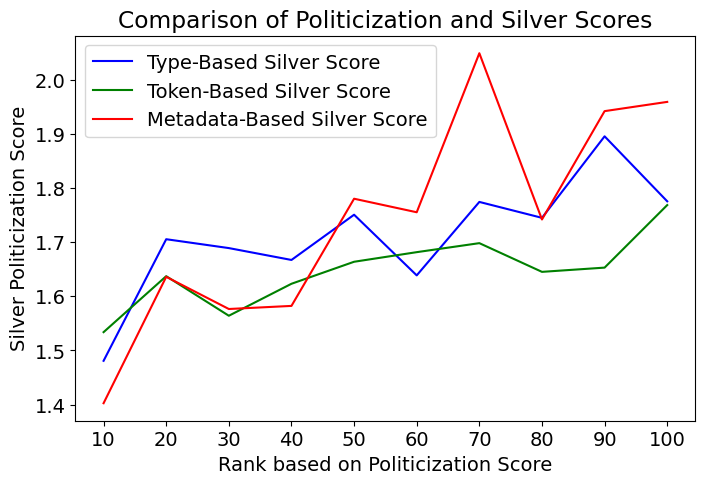

In [ ]:
# Plot
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 5))
plt.plot(df_type_binned['Bin_type'], \
         df_type_binned['silver_score_type'], \
         label='Type-Based Silver Score', color='blue')
plt.plot(df_token_binned['Bin_token'], \
         df_token_binned['silver_score_token'], \
         label='Token-Based Silver Score', color='green')
plt.plot(df_token_binned['Bin_token'],\
         df_token_binned['silver_score_metadata'], \
         label='Metadata-Based Silver Score', color='red')

# Labels and legend
plt.xlabel('Rank based on Politicization Score')
plt.ylabel('Silver Politicization Score')
plt.title('Comparison of Politicization and Silver Scores')
plt.legend()

max_bin = max(df_type_binned['Bin_type'].max(), df_token_binned['Bin_token'].max())
xticks = range(0, max_bin + 1)
xlabels = [(x + 1) * 10 for x in xticks]

plt.xticks(ticks=xticks, labels=xlabels)


We then identify the reports of interests by looking manually within the database:

### Type-based score reports

Here are the reports of interest for the reports ranked by type-based score:
*   The max score: PA00WB37
*   The min score: PDACY139
*   Outlier top 10 but quite low expert score: PA00W82Q (91e)
*   Outlier bottom 10 but quite high expert score: PA00XKDV (7e)

### Token-based score reports

Here are the reports of interest for the reports ranked by token-based score:



* The max score: PA00WH9F
*   The min score: PDACY139
*   Outlier top 10 but quite low expert score: PA00T1GR (93e)
*   Outlier bottom 10 but quite high expert score: PA00XKDV (7e)

### Metadata-based score reports

Here are the reports of interest for the reports ranked by token-based score against the metadata-based silver score:

*   The max score: PA00WH9F
*   The min score: PDACY139
*   Outlier top 10 but quite low expert score metadata: PA00KM8R(96e)
*   Outlier bottom 10 but quite high expert score metadata: PA00XKDV (4e)

### Report analysis

In this section we identify for each report the human-labelled metadata keywords (`USAID_Thesaurus_Term(s)_Clean`). This is part of an attempt to understand the specificities of a report that leads to some error in the politicization scores attribution. Again, for a deeper analysis please refer yourself to section 4.2.2 of the thesis.

#### Max scores

##### Metadata-based and token-based scores: PA00WH9F

In [ ]:
df[df['Document ID'] == 'PA00WH9F']['USAID_Thesaurus_Term(s)_Clean'].values[0]

['hiv aids',
 'adults',
 'age',
 'communicable diseases',
 'disease prevention control',
 'health facilities',
 'tuberculosis',
 'women']

##### Type-base score: PA00WB37

In [ ]:
df[df['Document ID'] == 'PA00WB37']['USAID_Thesaurus_Term(s)_Clean'].values[0]

['hiv aids',
 'access services',
 'child malnutrition',
 'disease prevention control',
 'health facilities',
 'infant nutrition',
 'tuberculosis',
 'women']

#### Bottom 10 outlier

PA00XKDV

In [ ]:
df[df['Document ID'] == 'PA00XKDV']['USAID_Thesaurus_Term(s)_Clean'].values[0]

['access services',
 'associations',
 'family health care',
 'health facilities',
 'mothers',
 'pregnancy',
 'reproductive health',
 'youth']

#### Top 10 outliers

##### Type-based score: PA00W82Q

In [ ]:
df[df['Document ID'] == 'PA00W82Q']['USAID_Thesaurus_Term(s)'].values[0]

['Case management',
 'Disease prevention and control',
 'Family health care',
 'Health facilities',
 'Malaria',
 'Reproduction',
 'Women']

##### Token-based: PA00T1GR

In [ ]:
df[df['Document ID'] == 'PA00T1GR']['USAID_Thesaurus_Term(s)'].values[0]

['HIV/AIDS',
 'Disease prevention and control',
 'Pharmaceuticals',
 'Pharmacies',
 'Pharmacists',
 'Regulations']

##### Metadata-based: PA00KM8R

In [ ]:
df[df['Document ID'] == 'PA00KM8R']['USAID_Thesaurus_Term(s)'].values[0]

['Commodities',
 'Demographic surveys',
 'Economic development',
 'Economics',
 'Finance',
 'Mass media']

## Nearest Neighbors analysis

In this section we develop a code for Nearest Neighbor analysis of keyword contextual embeddings. We will compare the 10 Nearest Neighbors of Republican and Democrat Keyword of certain keywords of interest (most politicized, least politicized, and outliers). This section only provides the code, for a deeper analysis please refere to the text of the thesis in section 4.1.3.

We work with the highest politicization scores with an expert score of 3 (expected politicized): 'family planning', 'reproductive health', and 'hivaids'.

NN gives a list of keywords that are similar with the keyword of interest. Even if Republican and Democratic embeddings obtain a similar list of NNs for a keyword, it does not mean they are handling the topic the same way (thus agreeing).

In [ ]:
def find_k_nearest_neighbors(embeddings_dict: Dict[str, Dict[str, torch.Tensor]],\
                             keyword: str, k: int, avg_k_embedding_party: str):
    '''
    Returns a List of Tuples containing the k Nearest Neighors of an input keyword
    and their cosine similarity score.

    Parameters:
        embeddings_dict: A dictionnary of embeddings (embeddings_dict).
        keyword: A Thesaurus Keyword.
        k: The number of Nearest Neighbors.
        party: The name of the variable to access the average keyword embedding
        for a certain party.

    Returns:
        A list of Tuples containing the k Nearest Neighbors and the cosine
        similarity score.
    '''
    if embeddings_dict[keyword][avg_k_embedding_party] == 'missing keyword':
      print('missing keyword')

    # we extract the keywords' embedding
    query_embedding = embeddings_dict[keyword][avg_k_embedding_party]
    # we compute the k NNs of the keyword
    NN = []
    for key, value in embeddings_dict.items():
        if avg_k_embedding_party in value and value[avg_k_embedding_party]\
         != 'missing keyword':
            #print(key, value)
            sim = cosine_similarity(query_embedding.unsqueeze(0), \
                                    value[avg_k_embedding_party].unsqueeze(0)).item()
            NN.append((key, sim))
    sort_NN = sorted(NN, key=lambda x: x[1], reverse=True)
    return [sim for sim in sort_NN if sim[0] != keyword][:k]

We generate the 10 nearest neighbors of both the Democratic and Republican embeddings for the three keywords of interest.

### 'family planning'

We generate the 10 nearest neighbors of both the Democratic and Republican embeddings for 'family planning'.

In [ ]:
nn_family_planning_D = find_k_nearest_neighbors(loaded_tensors, 'family planning', 10,'avg_keyword_embedding_D')
nn_family_planning_R = find_k_nearest_neighbors(loaded_tensors, 'family planning', 10,'avg_keyword_embedding_R')

In [ ]:
nn_family_planning_D

[('family planning services', 0.9858781099319458),
 ('voluntary family planning', 0.9759214520454407),
 ('reproductive health', 0.9513859152793884),
 ('health promotion', 0.9495489597320557),
 ('barriers family planning', 0.9442603588104248),
 ('health policy', 0.9437835812568665),
 ('health education', 0.9434225559234619),
 ('neonatal health', 0.9434146881103516),
 ('primary health care', 0.9431204795837402),
 ('health system strengthening', 0.9424835443496704)]

In [ ]:
nn_family_planning_R

[('family planning services', 0.9888051152229309),
 ('voluntary family planning', 0.9860672950744629),
 ('family planning education', 0.9805033802986145),
 ('family planning clinics', 0.9775254726409912),
 ('natural family planning methods', 0.9714757204055786),
 ('safe motherhood', 0.9593064785003662),
 ('family health care', 0.9559012055397034),
 ('reproductive health', 0.9525123238563538),
 ('post abortion care', 0.9501645565032959),
 ('maternal child health care', 0.9497084021568298)]

We then extract the keyword from the NNs output to check the difference between the two embeddings.

In [ ]:
keywords_D = set([item[0] for item in nn_family_planning_D])
keywords_R = set([item[0] for item in nn_family_planning_R])
unique_to_D = keywords_D-keywords_R
unique_to_R = keywords_R-keywords_D

print(f"Unique to the Democratic embedding: {unique_to_D}")
print(f"Unique to the Republican embedding: {unique_to_R}")

Unique to the Democratic embedding: {'health system strengthening', 'health policy', 'barriers family planning', 'health education', 'primary health care', 'neonatal health', 'health promotion'}
Unique to the Republican embedding: {'maternal child health care', 'safe motherhood', 'family planning clinics', 'family health care', 'natural family planning methods', 'post abortion care', 'family planning education'}


We see that the parties only have three keywords in common: 'family planning services', 'voluntary family planning', and 'reproductive health'.
The ranking of the NNs can provide an understanding of a party's priorities, for example, 'reproductive health' holds the third place within the Democratic list, while it is eighth on the Republican’s side. It could indicate that Democratic reports give more importance to ‘reproductive health’ in the context of family planning than Republican reports. Comparing the themes of the divergent NNs can also be insightful. The Democratic embedding contains six keywords out of seven mentioning ‘health’, and only one mention of the word ‘family’. On the other hand, the Republican embedding includes two times the word 'health' and five the word 'family'. This difference in frequencies may reflect divergent ideological priorities, general health being emphasized on the Democratic side and topics related to family on the Republican side.

### 'reproductive health'

We generate the 10 nearest neighbors of both the Democratic and Republican embeddings for 'reproductive health'.

In [ ]:
nn_reproductive_health_D = find_k_nearest_neighbors(loaded_tensors, 'reproductive health', 10,'avg_keyword_embedding_D')
nn_reproductive_health_R = find_k_nearest_neighbors(loaded_tensors, 'reproductive health', 10,'avg_keyword_embedding_R')

In [ ]:
nn_reproductive_health_D

[('health', 0.9688047170639038),
 ('primary health care', 0.9666106700897217),
 ('health education', 0.9660216569900513),
 ('health policy', 0.9643417596817017),
 ('health promotion', 0.9643309116363525),
 ('health services', 0.9638230800628662),
 ('health care', 0.9630839228630066),
 ('child health', 0.9629367589950562),
 ('maternal health care', 0.962005078792572),
 ('neonatal health', 0.9604408740997314)]

In [ ]:
nn_reproductive_health_R

[('health', 0.9696267247200012),
 ('primary health care', 0.9686007499694824),
 ('child health', 0.9660411477088928),
 ('health services', 0.9649593234062195),
 ('health education', 0.9647701382637024),
 ('health care', 0.9645496010780334),
 ('health policies', 0.9640173316001892),
 ('health policy', 0.9639159440994263),
 ('maternal health care', 0.9636404514312744),
 ('health promotion', 0.9622464776039124)]

We then extract the keyword from the NNs output to check the difference between the two embeddings.

In [ ]:
keywords_D = set([item[0] for item in nn_reproductive_health_D ])
keywords_R = set([item[0] for item in nn_reproductive_health_R ])
unique_to_D = keywords_D-keywords_R
unique_to_R = keywords_R-keywords_D

print(f"Unique to the Democratic embedding: {unique_to_D}")
print(f"Unique to the Republican embedding: {unique_to_R}")

Unique to the Democratic embedding: {'neonatal health'}
Unique to the Republican embedding: {'health policies'}


We see that the two parties have nine NNs in common out of ten. The divergent keyword is 'neonatal health' for the Democratic embedding, and 'health policies' for the Republican embedding.
Similar NNs do not imply a similar ideology being shared between the parties on a topic, especially since this keyword obtains a high degree of politicization. In terms of vector space, the embeddings of the two parties for this keyword are quite "far" from one another. They obtain ten NNs vectorized from the sub-corpus of their respective party, which happen to be similar in this special case.
The common keywords are mostly affiliated with family planning and general health. In this example, the Nearest Neighbors approach does not provide insights into the ideological differences but rather illustrates that two parties can associate similar vocabulary and concepts while holding different ideological stances, thus politicization.

### 'hivaids'

We generate the 10 nearest neighbors of both the Democratic and Republican embeddings for 'hivaids'.

In [ ]:
nn_hivaids_D = find_k_nearest_neighbors(loaded_tensors, 'hivaids', 10,'avg_keyword_embedding_D')
nn_hivaids_R = find_k_nearest_neighbors(loaded_tensors, 'hivaids', 10,'avg_keyword_embedding_R')

In [ ]:
nn_hivaids_D

[('new hiv infections', 0.9537389278411865),
 ('pharmaceuticals', 0.9492400288581848),
 ('aids', 0.9416898488998413),
 ('community health workers', 0.939810574054718),
 ('health workers', 0.9377651214599609),
 ('health education', 0.9361191987991333),
 ('demographic health surveys dhs', 0.9359372854232788),
 ('health insurance', 0.9350404143333435),
 ('antiretroviral therapy art', 0.9348621964454651),
 ('health services', 0.9346932172775269)]

In [ ]:
nn_hivaids_R

[('new hiv infections', 0.956767737865448),
 ('pharmaceuticals', 0.9497865438461304),
 ('lactational amenorrhea method lam', 0.9432308077812195),
 ('health workers', 0.9421689510345459),
 ('community health workers', 0.9421197772026062),
 ('health commodities', 0.941441535949707),
 ('aids', 0.9413944482803345),
 ('medical supplies', 0.9372371435165405),
 ('health professionals', 0.9371872544288635),
 ('health committees', 0.9371662139892578)]

We then extract the keyword from the NNs output to check the difference between the two embeddings.

In [ ]:
keywords_D = set([item[0] for item in nn_hivaids_D ])
keywords_R = set([item[0] for item in nn_hivaids_R ])
unique_to_D = keywords_D-keywords_R
unique_to_R = keywords_R-keywords_D

print(f"Unique to the Democratic embedding: {unique_to_D}")
print(f"Unique to the Republican embedding: {unique_to_R}")

Unique to the Democratic embedding: {'antiretroviral therapy art', 'health services', 'health education', 'demographic health surveys dhs', 'health insurance'}
Unique to the Republican embedding: {'lactational amenorrhea method lam', 'health commodities', 'health professionals', 'medical supplies', 'health committees'}


Five common NNs are found between the two vector embeddings of the 'hivaids' keyword: 'new hiv infections', 'pharmaceuticals', 'community health workers', 'health workers', and 'aids'. Both parties seem to have an interest in direct services such as healthcare personnel and treatment access.

Out of the different keywords, the Democratic embedding ranks 'health education' as the third NN, which is a crucial aspect of HIV/AIDS prevention and control. This keyword is absent from the Republican embedding, which assigns the third place to 'lactational amenorrhea method lam', a fertility reduction method accepted by religious authorities and part of natural family planning. An explanation for the difference in keywords between Republican and Democratic embeddings is the different scopes of their interest in healthcare. Health services appear to be linked with the Democratic embedding ('health education', 'health insurance', and 'health services'), whereas the Republican embedding seems to place more emphasis on operational considerations ('health commodities', 'medical supplies', 'health professionals')